In [ ]:
pip install ydata-profiling


In [ ]:
pip install autoimpute

In [ ]:
pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 8.0 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from google.cloud import bigquery

# ---------------------------------------
# Load data from BigQuery
# ---------------------------------------
project_id = "ic-ai-solutions"
source_table = "insurance_dataset.insurance_dataset"

bq_client = bigquery.Client(project=project_id)

query = f"""
    SELECT * FROM `{project_id}.{source_table}`
"""

df = bq_client.query(query).to_dataframe()

df_clean = df.dropna(subset=["CLAIM3YEARS"])

print(df_clean.shape)
print(df_clean['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

(190039, 66)
CLAIM3YEARS
False    0.884492
True     0.115508
Name: proportion, dtype: Float64


In [ ]:
print(df.columns)

Index(['QUOTE_DATE', 'COVER_START', 'CLAIM3YEARS', 'P1_EMP_STATUS',
       'P1_PT_EMP_STATUS', 'BUS_USE', 'CLERICAL', 'AD_BUILDINGS',
       'RISK_RATED_AREA_B', 'SUM_INSURED_BUILDINGS', 'NCD_GRANTED_YEARS_B',
       'AD_CONTENTS', 'RISK_RATED_AREA_C', 'SUM_INSURED_CONTENTS',
       'NCD_GRANTED_YEARS_C', 'CONTENTS_COVER', 'BUILDINGS_COVER',
       'SPEC_SUM_INSURED', 'SPEC_ITEM_PREM', 'UNSPEC_HRP_PREM', 'P1_DOB',
       'P1_MAR_STATUS', 'P1_POLICY_REFUSED', 'P1_SEX', 'APPR_ALARM',
       'APPR_LOCKS', 'BEDROOMS', 'ROOF_CONSTRUCTION', 'WALL_CONSTRUCTION',
       'FLOODING', 'LISTED', 'MAX_DAYS_UNOCC', 'NEIGH_WATCH', 'OCC_STATUS',
       'OWNERSHIP_TYPE', 'PAYING_GUESTS', 'PROP_TYPE', 'SAFE_INSTALLED',
       'SEC_DISC_REQ', 'SUBSIDENCE', 'YEARBUILT', 'CAMPAIGN_DESC',
       'PAYMENT_METHOD', 'PAYMENT_FREQUENCY', 'LEGAL_ADDON_PRE_REN',
       'LEGAL_ADDON_POST_REN', 'HOME_EM_ADDON_PRE_REN',
       'HOME_EM_ADDON_POST_REN', 'GARDEN_ADDON_PRE_REN',
       'GARDEN_ADDON_POST_REN', 'KEYCARE

In [ ]:
# Drop rows where COVER_START is missing
df_clean = df_clean.dropna(subset=["COVER_START"])

# Convert COVER_START to datetime if it isn't already
df_clean["COVER_START"] = pd.to_datetime(df_clean["COVER_START"], errors="coerce")

# Sort by COVER_START
df_clean = df_clean.sort_values(by="COVER_START")

# Split the DataFrame
df_subset = df_clean.head(100000)
df_withold = df_clean.iloc[100000:]

# Optional: reset index
df_subset = df_subset.reset_index(drop=True)
df_withold = df_withold.reset_index(drop=True)

# Inspect result
print("Subset shape:", df_subset.shape)
print("Withheld shape:", df_withold.shape)
print(df_subset.head(100))



Subset shape: (100000, 66)
Withheld shape: (89021, 66)
   QUOTE_DATE COVER_START  CLAIM3YEARS P1_EMP_STATUS P1_PT_EMP_STATUS  \
0         NaT  1992-11-05         True             R             None   
1         NaT  1992-11-06        False             R             None   
2         NaT  1992-11-09        False             R             None   
3         NaT  1992-11-09        False             R             None   
4         NaT  1992-11-09        False             R             None   
..        ...         ...          ...           ...              ...   
95        NaT  1993-11-16         True             R             None   
96        NaT  1993-11-17         True             R             None   
97        NaT  1993-11-17        False             R             None   
98        NaT  1993-11-18         True             R             None   
99        NaT  1993-11-18         True             R             None   

    BUS_USE  CLERICAL  AD_BUILDINGS  RISK_RATED_AREA_B  SUM_INSURED_

In [ ]:
essential_features = [
    # Policy details
    "QUOTE_DATE",
    "COVER_START",
    "POL_STATUS",
    "Police",

    # Client demographics
    "P1_DOB",
    "P1_SEX",
    "P1_MAR_STATUS",
    "P1_EMP_STATUS",

    # Property characteristics
    "PROP_TYPE",
    "BEDROOMS",
    "YEARBUILT",
    "ROOF_CONSTRUCTION",
    "WALL_CONSTRUCTION",

    # Coverage and claims history
    "CLAIM3YEARS",
    "SUM_INSURED_BUILDINGS",
    "SUM_INSURED_CONTENTS",
    "NCD_GRANTED_YEARS_C",

    # Security features
    "APPR_ALARM",
    "APPR_LOCKS",
    "SAFE_INSTALLED",
    "NEIGH_WATCH"
]

df_select = df_subset[essential_features]
print(df_select['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

df_select = df_select.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)
for col in df_select.select_dtypes(include='category').columns:
    df_select[col] = df_select[col].cat.codes

# Ensure birth date is datetime
df_select['P1_DOB'] = pd.to_datetime(df_select['P1_DOB'], errors='coerce')
# today = pd.to_datetime("today")
today = pd.to_datetime("2013-01-01")
print("Today: ",today)
# Basic year difference
df_select['age'] = today.year - df_select['P1_DOB'].dt.year

# Subtract 1 if birthday hasn't occurred yet this year
has_had_birthday = (
    (df_select['P1_DOB'].dt.month < today.month) |
    ((df_select['P1_DOB'].dt.month == today.month) & (df_select['P1_DOB'].dt.day <= today.day))
)

df_select['age'] -= ~has_had_birthday
print(df_select['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

df_select_no_date = df_select.drop(["QUOTE_DATE","COVER_START","P1_DOB","Police"],axis = 1)
print(df_select_no_date['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

bool_cols = df_select_no_date.select_dtypes(include='boolean').columns
df_select_no_date[bool_cols] = df_select_no_date[bool_cols].astype('Int8')
print(df_select_no_date['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

for col in df_select_no_date.columns:
    if pd.api.types.is_integer_dtype(df_select_no_date[col]):
        df_select_no_date[col] = df_select_no_date[col].astype('float64')
print(df_select_no_date['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

# Drop constant columns
df_select_no_date = df_select_no_date.loc[:, df_select_no_date.nunique() > 1]
# print(df_select_no_date.head(10))
print(df_select_no_date['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

CLAIM3YEARS
False    0.8652
True     0.1348
Name: proportion, dtype: Float64
Today:  2013-01-01 00:00:00
CLAIM3YEARS
False    0.8652
True     0.1348
Name: proportion, dtype: Float64
CLAIM3YEARS
False    0.8652
True     0.1348
Name: proportion, dtype: Float64
CLAIM3YEARS
0    0.8652
1    0.1348
Name: proportion, dtype: Float64
CLAIM3YEARS
0.0    0.8652
1.0    0.1348
Name: proportion, dtype: float64
CLAIM3YEARS
0.0    0.8652
1.0    0.1348
Name: proportion, dtype: float64


In [ ]:
essential_features = [
    # Policy details
    "QUOTE_DATE",
    "COVER_START",
    "POL_STATUS",
    "Police",

    # Client demographics
    "P1_DOB",
    "P1_SEX",
    "P1_MAR_STATUS",
    "P1_EMP_STATUS",

    # Property characteristics
    "PROP_TYPE",
    "BEDROOMS",
    "YEARBUILT",
    "ROOF_CONSTRUCTION",
    "WALL_CONSTRUCTION",

    # Coverage and claims history
    "CLAIM3YEARS",
    "SUM_INSURED_BUILDINGS",
    "SUM_INSURED_CONTENTS",
    "NCD_GRANTED_YEARS_C",

    # Security features
    "APPR_ALARM",
    "APPR_LOCKS",
    "SAFE_INSTALLED",
    "NEIGH_WATCH"
]

df_select = df_withold[essential_features]
print(df_select['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

df_select = df_select.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)
for col in df_select.select_dtypes(include='category').columns:
    df_select[col] = df_select[col].cat.codes

# Ensure birth date is datetime
df_select['P1_DOB'] = pd.to_datetime(df_select['P1_DOB'], errors='coerce')
# today = pd.to_datetime("today")
today = pd.to_datetime("2013-01-01")
print("Today: ",today)
# Basic year difference
df_select['age'] = today.year - df_select['P1_DOB'].dt.year

# Subtract 1 if birthday hasn't occurred yet this year
has_had_birthday = (
    (df_select['P1_DOB'].dt.month < today.month) |
    ((df_select['P1_DOB'].dt.month == today.month) & (df_select['P1_DOB'].dt.day <= today.day))
)

df_select['age'] -= ~has_had_birthday
print(df_select['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

df_select_no_date = df_select.drop(["QUOTE_DATE","COVER_START","P1_DOB","Police"],axis = 1)
print(df_select_no_date['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

bool_cols = df_select_no_date.select_dtypes(include='boolean').columns
df_select_no_date[bool_cols] = df_select_no_date[bool_cols].astype('Int8')
print(df_select_no_date['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

for col in df_select_no_date.columns:
    if pd.api.types.is_integer_dtype(df_select_no_date[col]):
        df_select_no_date[col] = df_select_no_date[col].astype('float64')
print(df_select_no_date['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

# Drop constant columns
df_select_no_date = df_select_no_date.loc[:, df_select_no_date.nunique() > 1]
# print(df_select_no_date.head(10))
print(df_select_no_date['CLAIM3YEARS'].value_counts(dropna = False,normalize=True))

CLAIM3YEARS
False    0.906112
True     0.093888
Name: proportion, dtype: Float64
Today:  2013-01-01 00:00:00
CLAIM3YEARS
False    0.906112
True     0.093888
Name: proportion, dtype: Float64
CLAIM3YEARS
False    0.906112
True     0.093888
Name: proportion, dtype: Float64
CLAIM3YEARS
0    0.906112
1    0.093888
Name: proportion, dtype: Float64
CLAIM3YEARS
0.0    0.906112
1.0    0.093888
Name: proportion, dtype: float64
CLAIM3YEARS
0.0    0.906112
1.0    0.093888
Name: proportion, dtype: float64


In [ ]:
print(df_select_no_date.columns)

Index(['POL_STATUS', 'P1_SEX', 'P1_MAR_STATUS', 'P1_EMP_STATUS', 'PROP_TYPE',
       'BEDROOMS', 'YEARBUILT', 'ROOF_CONSTRUCTION', 'WALL_CONSTRUCTION',
       'CLAIM3YEARS', 'SUM_INSURED_BUILDINGS', 'SUM_INSURED_CONTENTS',
       'NCD_GRANTED_YEARS_C', 'APPR_ALARM', 'APPR_LOCKS', 'SAFE_INSTALLED',
       'NEIGH_WATCH', 'age'],
      dtype='object')


# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

features = [col for col in df_select_no_date.columns if col not in ['CLAIM3YEARS']]
X = df_select_no_date[features]
y = df_select_no_date['CLAIM3YEARS'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train_enc = pd.get_dummies(X_train)
X_test_enc = pd.get_dummies(X_test)

# Align columns in case train/test have mismatched categories
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)


In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train_enc, y_train)

# Avoid: model
print("Model trained successfully.")


Model trained successfully.


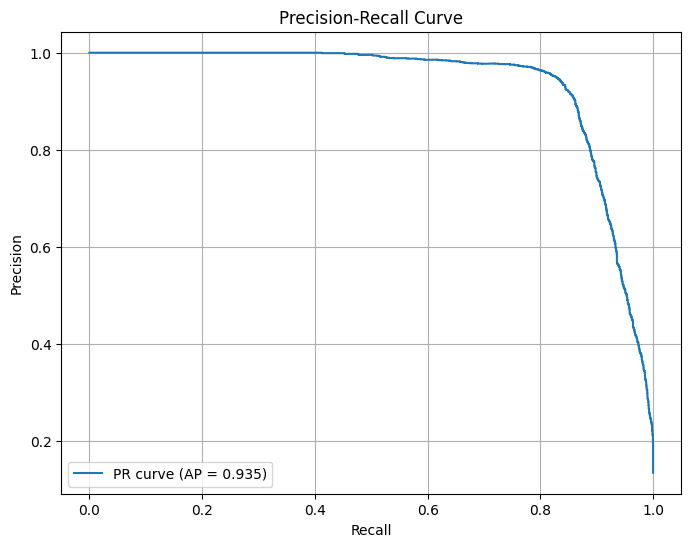

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict probabilities instead of labels
y_scores = model.predict_proba(X_test_enc)[:, 1]  # probability for class 1 (claim)

# Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Compute average precision (area under PR curve)
avg_precision = average_precision_score(y_test, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR curve (AP = {avg_precision:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_enc)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[17147   157]
 [  432  2264]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     17304
           1       0.94      0.84      0.88      2696

    accuracy                           0.97     20000
   macro avg       0.96      0.92      0.93     20000
weighted avg       0.97      0.97      0.97     20000



In [ ]:
# Reuse the same feature list used in training
features = [col for col in df.columns if col not in ['CLAIM3YEARS', 'QUOTE_DATE', 'COVER_START', 'P1_DOB', 'Police']]
X_withold = df_withold[features]
y_withold = df_withold['CLAIM3YEARS'].astype(int)  # assumed already imputed

# Encode same as training
X_withold_enc = pd.get_dummies(X_withold)

# Align columns with training features
X_withold_enc = X_withold_enc.reindex(columns=X_train_enc.columns, fill_value=0)
y_scores = model.predict_proba(X_withold_enc)[:, 1]  # probability of class 1


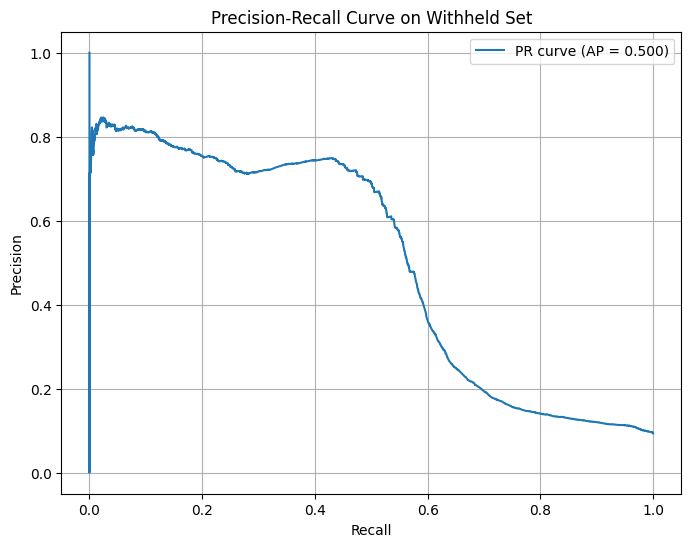

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_withold, y_scores)
avg_precision = average_precision_score(y_withold, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR curve (AP = {avg_precision:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve on Withheld Set")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import re
import pandas as pd
from ydata_profiling import ProfileReport
# Create the profile
profile = ProfileReport(df_select_no_date, title="Feature Analysis For insurance", explorative=True)

# Save to HTML
profile.to_file("feature_analysis_insure_100k_sam.html")
from google.colab import files
files.download("feature_analysis_insure_100k_sam.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:01<00:00, 10.77it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("feature_analysis_insure.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

joblib.dump(model, "xgb_model.pkl")


['xgb_model.pkl']

In [ ]:
%%bash
gsutil cp xgb_model.pkl gs://your-bucket-name/models/xgb_model.pkl